In [ ]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().resolve().parents[2]))
from bin.main import get_path
from bin.models.option_stats_model_setup import data as options_data
from bin.price.db_connect import Prices as price_data
from bin.models.anom.model import StackedAnomalyModel
from bin.models.anom.icr import IncrementalAnomalyModel
connections = get_path('../../../')
data_connection = options_data(connections)

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

stocks = data_connection.stocks['equities'] + data_connection.stocks['market']
stock = np.random.choice(stocks,1)[0]
print(stock)


x, y = data_connection._returnxy(stock, end_date = "2025-01-01")

def format_y(y, direction = 'both', threshold = 0.02):
    """
    Format y to find anomalous data points based on the specified direction and threshold.
    """
    assert direction in ['both','bullish','bearish'], "Direction must be 'both', 'bullish', or 'bearish'."
    if direction == 'both':
        out =  np.where(np.abs(y) > threshold, 1, 0)
        return pd.Series(out, index=y.index)
    elif direction == 'bullish':
        out =  np.where(y > threshold, 1, 0)
        return pd.Series(out, index=y.index)
    elif direction == 'bearish':
        out =  np.where(y < -threshold, 1, 0)
        return pd.Series(out, index=y.index)



y_clf = format_y(y, direction='both', threshold=0.01)
anom, norm = y_clf.value_counts()
print(f"Anomalous data points: {anom}, Normal data points: {norm}, Total data points: {len(y_clf)}")


run
Anomalous data points: 596, Normal data points: 118, Total data points: 714


In [68]:
value_count_dict = {}
data_dictionary = {}
price_dictionary = {}
for stock in stocks:
    x, y = data_connection._returnxy(stock, start_date = "2023-10-01")
    y_clf = format_y(y, direction='bullish', threshold=0.01)
    try:
        norm, anom = y_clf.value_counts()
        value_count_dict[stock] = {
            'anomalous': anom,
            'normal': norm,
            'total': len(y_clf)
        }

        data_dictionary[stock] = {
            'x': x,
            'y': y,
            'y_clf': y_clf
        }
        price_dictionary[stock] = data_connection.price_data(stock)["2023-10-01":]

    except Exception as e:
        # print(f"Error processing stock {stock}: {e}")
        pass


# Convert the dictionary to a DataFrame for better visualization
value_count_df = pd.DataFrame.from_dict(value_count_dict, orient='index')
value_count_df['pct_anom'] = value_count_df['anomalous'] / value_count_df['total']
value_count_df.sort_values(by='pct_anom', ascending=False, inplace=True)
value_count_df[value_count_df.total > 100]

,anomalous,normal,total,pct_anom
hood,160,205,365,0.438356
hims,115,149,264,0.435606
coin,156,209,365,0.427397
arm,117,159,276,0.423913
sofi,151,208,359,0.420613
...,...,...,...,...
v,52,313,365,0.142466
k,50,315,365,0.136986
ko,46,319,365,0.126027
spy,42,323,365,0.115068


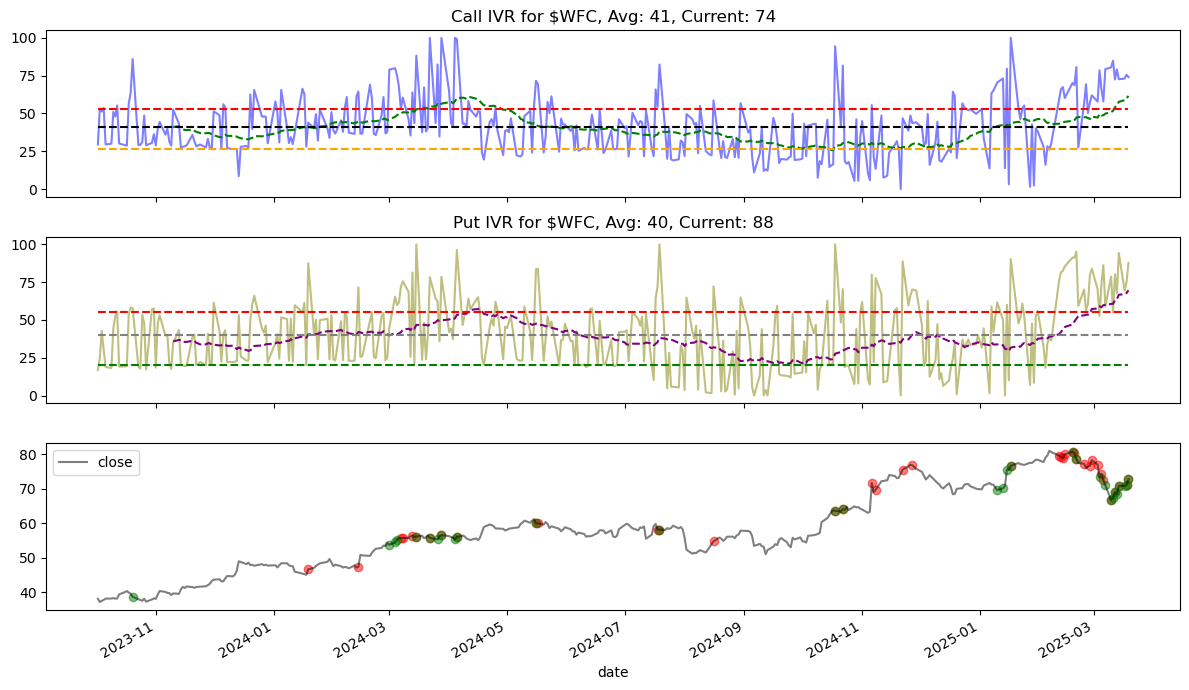

In [103]:
stocks = list(data_dictionary.keys())
stock = np.random.choice(stocks,1)

price_perf = price_dictionary[stock[0]].copy()
call_vol = data_dictionary.get(stock[0])['x']['call_ivr'].copy().tail(5000)
put_vol = data_dictionary.get(stock[0])['x']['put_ivr'].copy().tail(5000)
call_cheap, call_expensive = call_vol.describe()['25%'], call_vol.describe()['75%']
put_cheap, put_expensive = put_vol.describe()['25%'], put_vol.describe()['75%']

# Align the price data with the volume data
price_perf = price_perf.loc[call_vol.index.intersection(put_vol.index)].copy()
call_vol = call_vol.loc[price_perf.index].copy()
put_vol = put_vol.loc[price_perf.index].copy()

# Plotting
fig, ax = plt.subplots(3,1, figsize=(12, 7))
ax = ax.flatten()

# Call Plot 
call_vol.plot(ax=ax[0], color='blue', label='Call Volume', alpha = 0.5)
call_vol.rolling(30).mean().plot(ax=ax[0], color='green', label='30-Day Avg Call Volume', linestyle='--')
ax[0].hlines(call_vol.mean(), xmin=call_vol.index.min(), xmax=call_vol.index.max(), color='black', linestyle='--', label='Mean Call Volume')
ax[0].hlines(call_cheap, xmin=call_vol.index.min(), xmax=call_vol.index.max(), color='orange', linestyle='--', label='25% Call IVR')
ax[0].hlines(call_expensive, xmin=call_vol.index.min(), xmax=call_vol.index.max(), color='red', linestyle='--', label='75% Call IVR')
ax[0].set_title(f"Call IVR for ${stock[0].upper()}, Avg: {call_vol.mean():,.0f}, Current: {call_vol.iloc[-1]:,.0f}")


## Put Plot 
put_vol.plot(ax=ax[1], color='olive', label='Put Volume', alpha = 0.5)
put_vol.rolling(30).mean().plot(ax=ax[1], color='purple', label='30-Day Avg Put Volume', linestyle='--')
ax[1].hlines(put_cheap, xmin=put_vol.index.min(), xmax=put_vol.index.max(), color='green', linestyle='--', label='25% Put IVR')
ax[1].hlines(put_vol.mean(), xmin=put_vol.index.min(), xmax=put_vol.index.max(), color='grey', linestyle='--', label='Mean Put Volume')
ax[1].hlines(put_expensive, xmin=put_vol.index.min(), xmax=put_vol.index.max(), color='red', linestyle='--', label='75% Put IVR')
ax[1].set_title(f"Put IVR for ${stock[0].upper()}, Avg: {put_vol.mean():,.0f}, Current: {put_vol.iloc[-1]:,.0f}")


# Price Plot 
price_perf[['close']].plot(ax=ax[2], color='black', label='Price Performance', alpha=0.5)

# Ensure alignment of indices before applying conditions
aligned_put_vol = put_vol.loc[price_perf.index]
aligned_call_vol = call_vol.loc[price_perf.index]

# Red scatter plot for when put IVR is above the 75% threshold
thresh = 70
ax[2].scatter(aligned_put_vol.index[aligned_put_vol > thresh], price_perf.loc[aligned_put_vol > thresh, 'close'], color='red', label='High Put IVR', alpha=0.5)
ax[2].scatter(aligned_call_vol.index[aligned_call_vol > thresh], price_perf.loc[aligned_call_vol > thresh, 'close'], color='green', label='High Call IVR', alpha=0.5)

fig.autofmt_xdate()
fig.tight_layout()

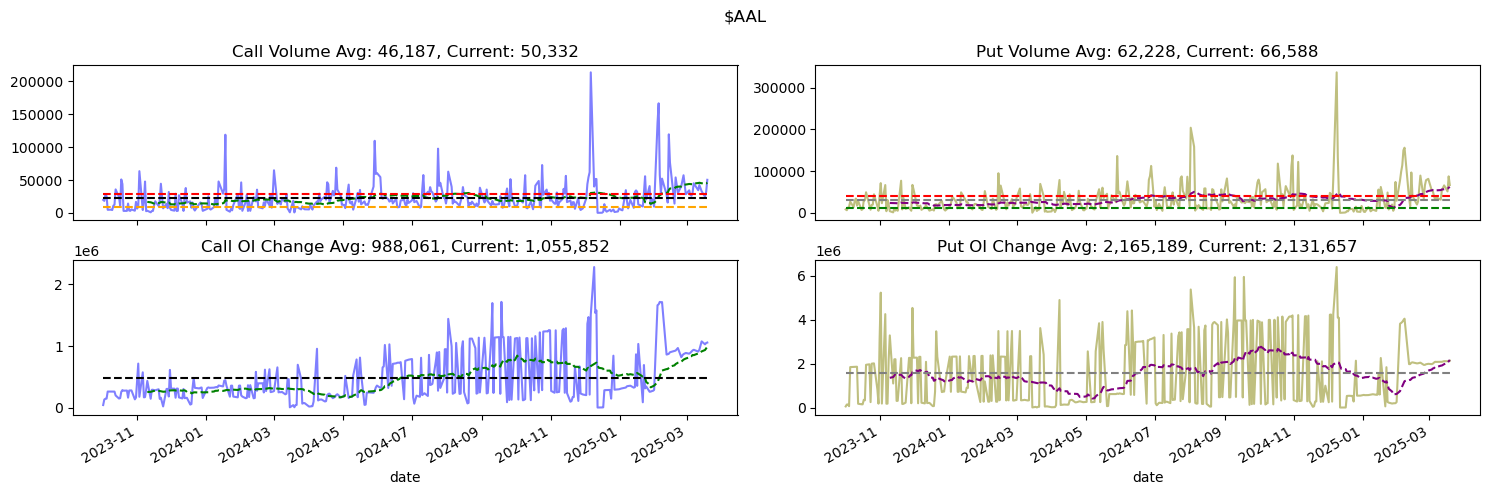

In [102]:
call_vol = data_dictionary.get(stock[0])['x']['call_vol'].copy().tail(500)
call_oi_chng = data_dictionary.get(stock[0])['x']['call_oi'].copy().tail(500)
put_vol = data_dictionary.get(stock[0])['x']['put_vol'].copy().tail(500)
put_oi_chng = data_dictionary.get(stock[0])['x']['put_oi'].copy().tail(500)
call_cheap, call_expensive = call_vol.describe()['25%'], call_vol.describe()['75%']
put_cheap, put_expensive = put_vol.describe()['25%'], put_vol.describe()['75%']

fig, ax = plt.subplots(2, 2, figsize=(15, 5))
ax = ax.flatten()

# Call Plot 
call_vol.plot(ax=ax[0], color='blue', label='Call Volume', alpha = 0.5)
call_vol.rolling(30).mean().plot(ax=ax[0], color='green', label='30-Day Avg Call Volume', linestyle='--')
ax[0].hlines(call_vol.mean(), xmin=call_vol.index.min(), xmax=call_vol.index.max(), color='black', linestyle='--', label='Mean Call Volume')
ax[0].hlines(call_cheap, xmin=call_vol.index.min(), xmax=call_vol.index.max(), color='orange', linestyle='--', label='25% Call IVR')
ax[0].hlines(call_expensive, xmin=call_vol.index.min(), xmax=call_vol.index.max(), color='red', linestyle='--', label='75% Call IVR')
ax[0].set_title(f"Call Volume Avg: {call_vol.rolling(30).mean().iloc[-1]:,.0f}, Current: {call_vol.iloc[-1]:,.0f}")


## Put Plot 
put_vol.plot(ax=ax[1], color='olive', label='Put Volume', alpha = 0.5)
put_vol.rolling(30).mean().plot(ax=ax[1], color='purple', label='30-Day Avg Put Volume', linestyle='--')
ax[1].hlines(put_cheap, xmin=put_vol.index.min(), xmax=put_vol.index.max(), color='green', linestyle='--', label='25% Put IVR')
ax[1].hlines(put_vol.mean(), xmin=put_vol.index.min(), xmax=put_vol.index.max(), color='grey', linestyle='--', label='Mean Put Volume')
ax[1].hlines(put_expensive, xmin=put_vol.index.min(), xmax=put_vol.index.max(), color='red', linestyle='--', label='75% Put IVR')
ax[1].set_title(f"Put Volume Avg: {put_vol.rolling(30).mean().iloc[-1]:,.0f}, Current: {put_vol.iloc[-1]:,.0f}")


# Call OI Change Plot
call_oi_chng.plot(ax=ax[2], color='blue', label='Call OI Change', alpha = 0.5)
call_oi_chng.rolling(30).mean().plot(ax=ax[2], color='green', label='30-Day Avg Call OI Change', linestyle='--')
ax[2].hlines(call_oi_chng.mean(), xmin=call_oi_chng.index.min(), xmax=call_oi_chng.index.max(), color='black', linestyle='--', label='Mean Call OI Change')
ax[2].set_title(f"Call OI Change Avg: {call_oi_chng.rolling(30).mean().iloc[-1]:,.0f}, Current: {call_oi_chng.iloc[-1]:,.0f}")

# Put OI Change Plot
put_oi_chng.plot(ax=ax[3], color='olive', label='Put OI Change', alpha = 0.5)
put_oi_chng.rolling(30).mean().plot(ax=ax[3], color='purple', label='30-Day Avg Put OI Change', linestyle='--')
ax[3].hlines(put_oi_chng.mean(), xmin=put_oi_chng.index.min(), xmax=put_oi_chng.index.max(), color='grey', linestyle='--', label='Mean Put OI Change')
ax[3].set_title(f"Put OI Change Avg: {put_oi_chng.rolling(30).mean().iloc[-1]:,.0f}, Current: {put_oi_chng.iloc[-1]:,.0f}")

fig.suptitle(f'${stock[0].upper()}')
fig.autofmt_xdate()
fig.tight_layout()

plt.show()

In [ ]:
features = data_dictionary[stock[0]]['x'].copy()
y = data_dictionary[stock[0]]['y'].copy()
df = pd.concat([features, y], axis=1)
df.corrwith(df['target']).sort_values(ascending=False)

target              1.000000
call_prem_chng      0.027705
put_prem_chng       0.027323
pcr                 0.023586
call_prem           0.019018
put_prem            0.018945
pcr_rank            0.002828
stock_volume        0.002734
call_oi_chng       -0.001008
put_oi_chng        -0.002439
put_spread         -0.006615
call_vol_chng      -0.013238
atm_iv_chng        -0.014247
put_vol_chng       -0.021274
put_spread_chng    -0.025655
put_oi             -0.031340
call_oi            -0.034134
otm_ivr            -0.039581
call_vol           -0.039910
call_ivr           -0.041239
call_spread        -0.042179
put_vol            -0.045906
atm_iv             -0.047773
call_spread_chng   -0.051040
put_ivr            -0.051948
atm_ivr            -0.053988
call_iv_chng       -0.055326
otm_iv             -0.069813
call_iv            -0.072571
put_iv             -0.080089
otm_iv_chng        -0.081727
put_iv_chng        -0.097913
dtype: float64